**Note!**

This notebook uses the `nilearn` package - which is not a requirement of `pynm` and must be installed.

To do so, uncomment the code in the cell below and run it.

In [24]:
#import sys
#!{sys.executable} -m pip install nilearn==0.9.2

In [2]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn.input_data import NiftiLabelsMasker
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC

/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# **Downstream Analyses**
In this tutorial we'll use a real dataset to demonstrate fitting a Normative Model on a held out training set.

## **Data Leakage**
Using a held out training set ensures that we don't have data leakage (contamination of the test set). 

Imagine fitting a Normative Model on all the available controls in a dataset and using it to generate scores for all subjects, as we've been doing so far. Now that we have the scores, we want to do further analyses. Say we want to train a prediction model, we split our data into a training and test set and continue as we normally would. However, we find that our prediction accuracy is way higher than we expected! 

This is actually evidence that we have contaminated the test set. The scores contain information from all the controls, so when we split the data afterwards the test set controls have already been "seen" in the training data. The effect will be more dramatic the more the model has corrected for the explanatory variables (age, sex, site etc.). 

We'll explore this problem in a prediction framework and how to implement the solution with PyNM.

## **Download and Process Data**
In both examples we'll use the ADHD resting-state dataset. The dataset consists of resting state fMRI scans for 40 subjects which are either controls or patients diagnosed with ADHD. Here we'll use `nilearn` to fetch the data and process it into connectomes, which are correlation matrices that capture how similar each pair of brain regions are in terms of their functional activity.

Our task will be to predict wether a given subject is a patient or control using their connectome.

First, we'll use nilearn to fetch the data. Running the cell below will download ~2 GB of data to your machine.

In [3]:
# Download the dataset
adhd = datasets.fetch_adhd(n_subjects=None)

Now that we have our data, we will need to process it from functional scans (4D data) into connectomes for each subject. To do that we need to download an atlas (to divide the brain into regions) and create `nilearn` objects to extract the activity from each region (`NiftiLabelsMasker`) and to compare the activity between regions (`ConnectivityMeasure`). 

Running this cell takes about a minute to process each connectome and downloads an atlas (~30MB). 

**Note:** 
We've sorted the `adhd.func` and `adhd.confounds` list of filenames to ensure that we are using the same ordering of subjects everywhere (ranked increasing by ID number).

In [4]:
# Download an atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Create the masker and correlation measure
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
correlation_measure = ConnectivityMeasure(kind='correlation')

# Get a connectome for each subject
mask = np.tril(np.ones((48,48),dtype=bool))
connectomes=[]
for func,conf in zip(np.sort(adhd.func),np.sort(adhd.confounds)):
    ts = masker.fit_transform(func, confounds=conf)
    corr = correlation_measure.fit_transform([ts])[0]
    connectomes.append(corr[mask])

connectomes = np.array(connectomes)

Now we'll build a DataFrame that we can use with PyNM. We'll grab the IDs, status (patient or control), gender, and age from the ADHD phenotypic information first and sort the values according to ID to match the order we processed the connectomes. Then we'll choose a random edge of the connectome to model for our example and add it to the dataframe.

In [6]:
# Create a DataFrame
pheno = pd.DataFrame([int(x) for x in pd.DataFrame(adhd.phenotypic)['Subject']],columns=['id'])
pheno['status'] = pd.DataFrame(adhd.phenotypic)['adhd']
pheno['gender'] = [(x=='"M"')*1 for x in pd.DataFrame(adhd.phenotypic)['sex']]
pheno['age'] = [x for x in pd.DataFrame(adhd.phenotypic)['age']]

# Sort the values by id (same sorting as above)
pheno.sort_values('id',inplace=True)
pheno.reset_index(inplace=True)

### Filter Edges

We have a lot of edges in our connectome and some might be more relevant than others for our prediction task (wether the subject is a patient or a control). To boost our signal to noise ration, we will filter our data to select the top 10% of edges based on their correlation with the response variable.

In [7]:
# Set the number of edges to choose
n_edges = int(connectomes.shape[1]*0.10)

# Find the correlation of each edge with the response variable
corr = []
for i in range(connectomes.shape[1]):
    y = connectomes[:,i]
    x = pheno['status']
    r = pearsonr(x,y)[0]
    corr.append(r)

# Create a DataFrame and sort it by the r values
edges = pd.DataFrame([corr], index = ['r']).transpose()
edges['r_abs'] = edges['r'].abs()
edges.sort_values('r_abs',inplace=True)

# Drop edges w/ NaN r values
edges = edges[edges['r'].notna()]

# Choose the top edges
top_edges = edges[-n_edges:].index.to_list()

/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [8]:
# Create a DataFrame for the edges and join it to pheno
edge_names = [f"edge_{i}" for i in top_edges]
df = pd.DataFrame(connectomes[:,top_edges],columns = edge_names)
pheno = pd.concat([pheno,df],axis=1)

### Visualize Data

Here we choose one of the top edges to vizualize.

<AxesSubplot: xlabel='age', ylabel='edge_200'>

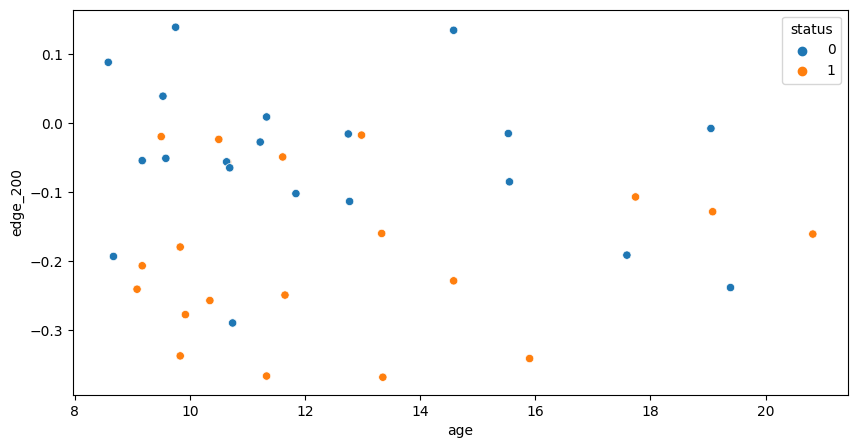

In [9]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y=edge_names[-1],data=pheno,hue='status')

## **Example 0**

Before we get into predicting the status (patient or control) of subjects using the deviance scores of a Normative Model, we'll establish a baseline by first using the raw connectome values.

In [10]:
# Get the data
X_0 = pheno[edge_names].to_numpy()
y_0 = pheno['status'].to_numpy()

# Create a classifier
svc = SVC()

# Create a CV object
cv = KFold(n_splits=10,shuffle=True)

# Run cross validation
accuracy = np.mean(cross_val_score(svc,X_0,y_0,scoring='accuracy',cv=cv))
print(f"Mean accuracy across 10 folds: {accuracy:.3f}")

Mean accuracy across 10 folds: 0.925


We'll be using the LOESS Normative Model fit with age as an explanatory variable, so we'll take a look at the relationship between age and status. We can see from the violin plot that the patient group has a slightly older mean age and they distribution between the two groups is unequal. If our Normative Model works as expected, the deviance scores should be independent of age. Since age is not homogeneous across the variable we are trying to predict, our accuracy should go down when we use the deviance scores for prediction.

<AxesSubplot: xlabel='status', ylabel='age'>

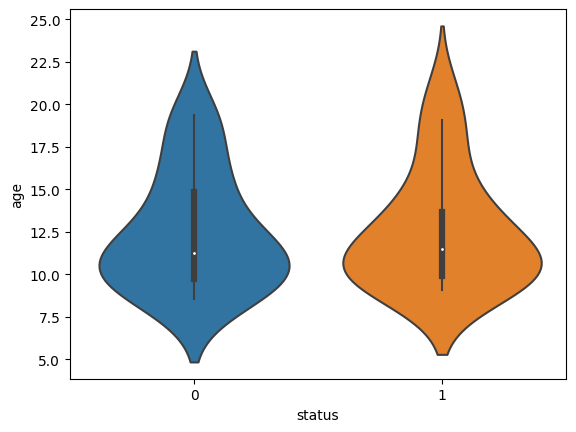

In [11]:
sns.violinplot(x='status',y='age',data=pheno)

## **Example 1**
First we'll look at the wrong way, first using all the controls to fit the Normative Models and then reusing the same controls for the prediction task.

![image4](image4.jpg)

### Fit Normative Models

Since we're fitting a Normative Model to each edge, we'll use the LOESS model in the interest of speed. We'll also silence the output of the cell using `%%capture` to avoid flooding our notebook.

In [12]:
%%capture

# Fit NM per edge
res = []
for i in reversed(range(n_edges)):
    # Initialize pynm w/ data, confounds & bin parameters
    m = PyNM(pheno,edge_names[i],'status',['age','c(gender)'], 
    bin_width=13, bin_spacing=3)
    
    # Run model & save results
    m.loess_normative_model()
    res.append(m.data['LOESS_z'])
results = pd.concat(res,axis=1)

We'll take a look at the fit of our last model to check if we're on track.

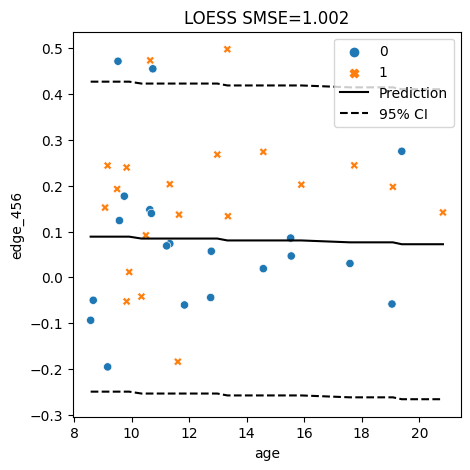

In [13]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

### Predict Status from Deviance Scores

Now we'll use the deviance scores from all our subjects and run our prediction using SVC on 10 folds of cross-validation. The mean accuracy should be about the same as the raw connectome values or a bit higher. This is counter to what we would expect, since we should be removing the effect of age which is correlated with the response variable. The performance is due to data leakage!

In [14]:
# Get the data
X_1 = results.to_numpy()
y_1 = m.data['status'].to_numpy()

# Create a classifier
svc = SVC()

# Create a CV object
cv = KFold(n_splits=10,shuffle=True)

# Run cross validation
accuracy = np.mean(cross_val_score(svc,X_1,y_1,scoring='accuracy',cv=cv))
print(f"Mean accuracy across 10 folds: {accuracy:.3f}")

Mean accuracy across 10 folds: 1.000


## **Example 2**
Now we'll demonstrate how to use PyNM to fit Normative Models on a held out set of controls so we can have clean data for our prediction task.

![image5](image5.jpg)

### Fit Normative Models on Held Out Controls

In order to use a held out set of controls for training, we'll need the `train_sample` parameter. It can be set to:
 1. A number in (0,1]
    - This is simplest usage that defines the sample size, PyNM will then select a random sample of the controls and use those as a training group. The number is the proportion of controls to use, the default value is 1 to use the full set of controls.
    - The subjects used in the sample are recorded in the column `'train_sample'` of the resulting PyNM.data object. Subjects used in the training sample are encoded as 1s, and the rest as 0s. 
 2. `'manual'`
    - It is also possible to specify exactly which subjects to use as a training group by providing a column in the input data labeled `'train_sample'` encoded the same way.

Here we'll use it by passing `train_sample=0.5` to select half of the available controls. We also need to specify a `seed` to fix the random sampling, this ensures that the same controls are chosen for each model.

We're again using `%%capture` to silence the output of the cell since we are running so many models, to see the output just comment out the line - it will print out for each model:

`Models will be fit with train sample size = 0.5: using 37/74 of controls.`

In [15]:
%%capture

# Fit NM per edge
res_clean = []
for i in reversed(range(n_edges)):
    # Initialize pynm w/ data, confounds & bin parameters
    m = PyNM(pheno,edge_names[i],'status',['age'],
            bin_width=13, bin_spacing=2,
            train_sample=0.5, # Set the size of the held out set
            seed=1) # Set a seed to keep held out set consistent across models
    
    # Run model
    m.loess_normative_model()

    # Only keep results from subjects outside train_sample
    res_clean.append(m.data[m.data['train_sample']!=1]['LOESS_z'])
results_clean = pd.concat(res_clean,axis=1)
results_clean['status'] = m.data[m.data['train_sample']!=1]['status']

Here we'll again take a look at the fit of our last model, but keep in mind that the 0/1 labels are now reflecting the `train_sample`. So 1s are the subjects that have been used for training, 0s have not.

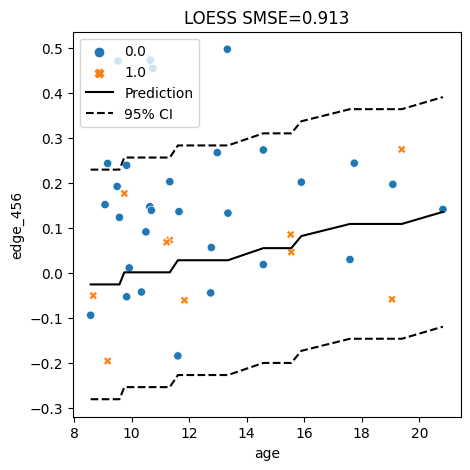

In [16]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

We can access the `train_sample` column of the data to see exactly what subjects have been selected.

In [17]:
# View number of subjects in each column
print('Total per column:')
print(m.data[['status','train_sample']].sum())

# View status and train_sample columns
m.data[['status','train_sample']]

Total per column:
status          20.0
train_sample    10.0
dtype: float64


,status,train_sample
0,1,0.0
1,1,0.0
2,0,0.0
3,0,1.0
4,0,1.0
5,1,0.0
6,1,0.0
7,1,0.0
8,1,0.0
9,1,0.0


### Predict Status from Deviance Scores

Now we'll use the deviance scores from the subjects not used to train the Normative Models and run our prediction using SVC on 10 folds of cross-validation. The mean accuracy should be a bit lower than it is using the raw connectome values since we've removed the effect of age.

In [18]:
# Get the data
X_2 = results_clean.to_numpy()
y_2 = results_clean['status'].to_numpy()

# Create a classifier
svc = SVC()

# Create a CV object
cv = KFold(n_splits=10,shuffle=True)

# Run cross validation
accuracy = np.mean(cross_val_score(svc,X_2,y_2,scoring='accuracy',cv=cv))
print(f"Mean accuracy across 10 folds: {accuracy:.3f}")

Mean accuracy across 10 folds: 0.767


### Manually Set Train Sample

Finally, we'll demonstrate using a manually specified training sample. Instead of running the models for each edge of the connectome, we'll just pick one to illustrate how to set up the DataFrame and instantiate the PyNM object.

Say we wanted to make sure our training sample was stratified by gender, we'll use `sklearn` to build the sample and add it to our DataFrame. **Note:** The column **must** be called `train_sample`!

In [21]:
# Define classes to stratify by
strat = pheno[pheno['status']==0]['gender'].to_numpy()

# Get ids to split
ids = pheno[pheno['status']==0]['id'].to_numpy()

# Create stratified sample
ids_train,_,_,_ = train_test_split(ids, np.ones(ids.size),stratify=strat)

# Add column to DataFrame
pheno['train_sample'] = 1*pheno['id'].isin(ids_train)

Now all we have to do is initialize PyNM with `train_sample` set to `'manual'` and we're done!

In [22]:
# Initialize pynm w/ data, confounds & bin parameters
m = PyNM(pheno,edge_names[10],'status',['age'],
            bin_width=13, bin_spacing=2,
            train_sample='manual') # Set to manual
    
# Run model & save results
m.loess_normative_model()

Models will be fit using specified training sample.


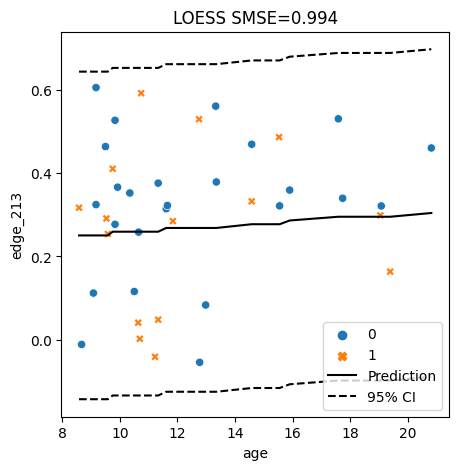

In [23]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

## **Summary**
- We need to avoid data leakage when we are using the results of Normative Models for downstream analyses
- We do this by using a held out training sample
- PyNM implements this using the `train_sample` parameter
- We can allow PyNM to randomly sample a proportion of the controls or manually specify which subjects to train with
- When using a random sample, we can also set a `seed` to fix the chosen controls.
- We can access the chosen sample by looking at the `train_sample` column of the model's `data` attribute.

### **Congrats!** You've reached the end of the tutorials!